Author: Ethan Herron 3-4-2020

This is my jupyter notebook for the book Deep Learning from Scratch by Seth Weidman. I will be following along with all of the code, and adding insights or questions I have along the way in these markdown cells.

In [96]:
#import libraries
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from typing import Callable, Dict, List, Tuple

TEST_ALL = False

## Boston Data

In [97]:
boston = load_boston()

In [98]:
data = boston.data
target = boston.target
features = boston.feature_names

## SciKit Learn Linear Regression

### Initial Data Prep

In [99]:
s = StandardScaler()
data = s.fit_transform(data)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

### Regression

In [101]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

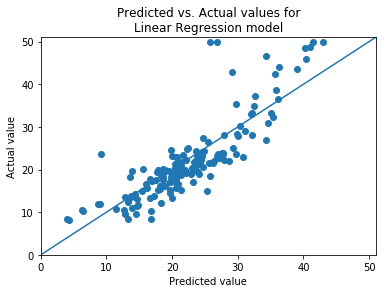

In [102]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nLinear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

### Test Changing Feature

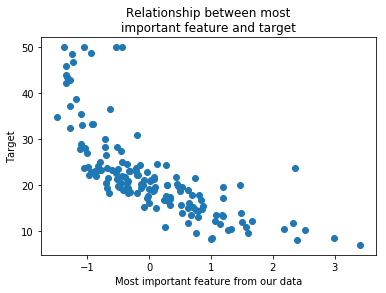

In [103]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target");

As you can see this is a non linear relationship. As our "most important" feature increases our target decreases in a nonlinear manner.

### Model Error

In [104]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Computes mean absolute error
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    '''
    Computes root mean squared error
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [105]:
print("Mean absolute error: ", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error: ", round(rmse(preds, y_test), 4))

Mean absolute error:  3.5671 
Root mean squared error:  5.0476


In [106]:
np.round(lr.coef_, 2)

array([[-1.01,  0.71,  0.28,  0.71, -2.21,  2.38,  0.71, -2.66,  2.63,
        -1.82, -2.33,  0.85, -4.19]])

## Manual Linear Regression

In [107]:
def forward_linear_regression(X_batch: ndarray, 
                              y_batch: ndarray, 
                              weights: Dict[str, ndarray]
                              ) -> Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step Linear regression
    '''
    #asser batch sizes of X and y are equal
    assert X_batch.shape[0] == y_batch.shape[0]
    
    #assert that we can matmul X with all weights
    assert X_batch.shape[1] == weights['W'].shape[0]
    
    #assert that B is a scalar
    assert weigths['B'].shape[0] == weights['B'].shape[1] == 1
    
    #Compute the operations on the forward pass
    N = np.dot(X_batch, weitghts['W'])
    
    P = N + weights['B']
    
    loss = np.mean(np.power(y_batch - P, 2))
    
    #save info computed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch
    
    return loss, forward_info

In [108]:
def to_2d_np(a: ndarray, type: str = "col") -> ndarray:
    '''
    Turns a 1D tensor into a 2D tensor
    '''
    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [109]:
def permute_data(X: ndarray, y: ndarray):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [110]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear reg model
    '''
    batch_size = forward_info['X'].shape[0]
    
    dLdP = -2 * (forward_info['y'] - forward_info['P'])
    
    dPdN = np.ones_like(forward_info['N'])
    
    dPdB = np.ones_like(weights['B'])
    
    dLdN = dLdP * dPdN
    
    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    #use matmul, dNdW must be on the left for the dimensions to align
    dLdW = np.dot(dNdW, dLdN)
    
    #must sum along the dimension representing the batch size
    dLdB = (dLdP * dPdB).sum(axis=0)
    
    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB
    
    return loss_gradients

In [111]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray, 
                   y: ndarray, 
                   start: int = 0, 
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2, \
    "X and y must be 2 dimensional"
    
    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
        
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [112]:
def forward_loss(X: ndarray, y: ndarray, weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:
    '''
    Generate predictions and calculate loss
    '''
    N = np.dot(X, weights['W'])
    
    P = N + weights['B']
    
    loss = np.mean(np.power(y - P, 2))
    
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y
    
    return forward_info, loss

In [113]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    Initialize weights on first forward pass of model
    '''
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B
    
    return weights

In [114]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100, 
          return_losses: bool = False,
          return_weights: bool = False,
          seed: int = 1) -> None:
    '''
    Train the model for a certain number of epochs
    '''
    if seed:
        np.random.seed(seed)
    start = 0
    
    #Initialize weights
    weights = init_weights(X.shape[1])
    
    #Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []
        
    for i in range(n_iter):
        
        #Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X,y)
            start = 0
            
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
        
        #Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)
        
        if return_losses:
            losses.append(loss)
            
        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
            
    if return_weights:
        return losses, weights
    
    return None

In [115]:
train_info = train(X_train, y_train,
                   n_iter = 1000, 
                   learning_rate = 0.001, 
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

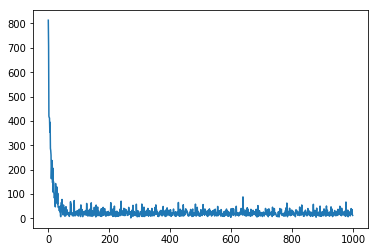

In [116]:
plt.plot(list(range(1000)), losses);

In [117]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    '''
    Generate predictions from the manual linear regression
    '''
    N = np.dot(X, weights['W'])
    
    return N + weights['B']

In [118]:
preds = predict(X_test, weights)

In [119]:
print("Mean absolute error: ", round(mae(preds, y_test), 4), "\n" "Root mean squared error: ", round(rmse(preds, y_test), 4))

Mean absolute error:  3.5644 
Root mean squared error:  5.0497


In [120]:
np.round(y_test.mean(), 4)

22.0776

In [40]:
np.round(rmse(preds, y_test) / y_test.mean(), 4)

0.2287

the above metric shows that rmse is ~23% on average of y

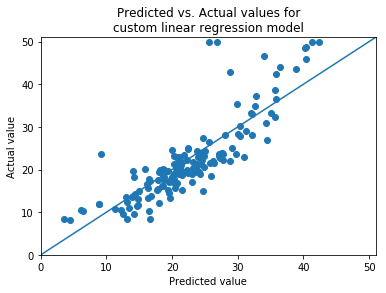

In [121]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model");
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

### Coefficients

In [122]:
np.round(weights['W'].reshape(-1), 4)

array([-1.0954,  0.7353,  0.1977,  0.7475, -2.2849,  2.2006,  0.7195,
       -2.6384,  2.5358, -1.6892, -2.3162,  0.8435, -4.2553])

In [123]:
np.round(lr.coef_, 4)

array([[-1.0148,  0.7065,  0.276 ,  0.7092, -2.206 ,  2.3793,  0.7133,
        -2.6625,  2.6325, -1.8172, -2.3266,  0.8465, -4.1889]])

In [44]:
np.round(weights['B'], 4)

array([[22.6312]])

In [124]:
np.round(lr.intercept_, 4)

array([22.6195])

The coefficients are the 'same' as in scikit learn and the manual linear regression, although you can see slight discrepancies in the weights, but both have very similiar intercepts. As shown earlier they had almost identical RMSE and MAE, but since the weights are different they are different lines. Similar errors, but 'different' lines can be attributed to the dataset, at least that is what I would conclude. 

### Theoretical relationship between most important feature and the target

In [125]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

In [126]:
test_feature = np.concatenate([a, b], axis=1)
preds = predict(test_feature, weights)[:, 0]

(6, 51)

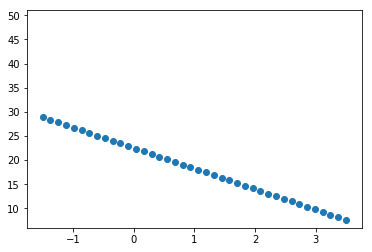

In [127]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])

## Manual Neural Network

In [128]:
def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-1.0 * x))

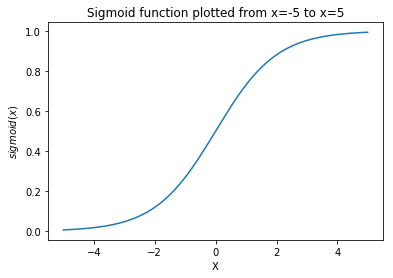

In [129]:
plt.plot(np.arange(-5, 5, 0.01),
         sigmoid(np.arange(-5, 5, 0.01)));
plt.title("Sigmoid function plotted from x=-5 to x=5")
plt.xlabel("X")
plt.ylabel("$sigmoid(x)$");

So here neural networks utilize the sigmoid function because  is monotonic, and it also allows inputs to maintain their polarity? (whether they are positive of negative, I don't know if that's the correct word), unlike another nonlinear function such as x^2. sigmoid functions are also either 1 or zero for varying inputs, which allows the operations ocurring within the network to retain its simplicity. like the game of life, the larger number of binary or simple operations can create very large and complex systems. THis concept was explained to me from Lex Fridman's podcast. 

In [163]:
def init_weights(input_size: int,
                 hidden_size: int) -> Dict[str, ndarray]:
    '''
    Initialize weights during the forward pass for step by step neural network model.
    '''
    weights_nn: Dict[str, ndarray] = {}
    weights_nn['W1'] = np.random.randn(input_size, hidden_size)
    weights_nn['B1'] = np.random.randn(1, hidden_size)
    weights_nn['W2'] = np.random.randn(hidden_size, 1)
    weights_nn['B2'] = np.random.randn(1, 1)
    return weights_nn

In [187]:
def forward_loss_nn(X: ndarray,
                 y: ndarray, 
                 weights_nn: Dict[str, ndarray]
                 ) -> Tuple[Dict[str, ndarray], float]:
    '''
    COmpute the forward pass and the loss for the manaul nerual net
    '''
    M1 = np.dot(X, weights_nn['W1'])
    
    N1 = M1 + weights_nn['B1']
    
    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights_nn['W2'])
    
    P = M2 + weights_nn['B2']
    
    loss_nn = np.mean(np.power(y - P, 2))
    
    forward_info_nn: Dict[str, ndarray] = {}
    forward_info_nn['X'] = X
    forward_info_nn['M1'] = M1
    forward_info_nn['N1'] = N1
    forward_info_nn['O1'] = O1
    forward_info_nn['M2'] = M2
    forward_info_nn['P'] = P
    forward_info_nn['y'] = y
    
    return forward_info_nn, loss_nn

In [176]:
def loss_gradients(forward_info_nn: Dict[str, ndarray],
                   weights_nn: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute the partial derivatives of the loss w/ respect to each 
    parameter in the neural net
    '''
    dLdP = -(forward_info_nn['y'] - forward_info_nn['P'])
    
    dPdM2 = np.ones_like(forward_info_nn['M2'])
    
    dLdM2 = dLdP * dPdM2
    
    dPdB2 = np.ones_like(weights_nn['B2'])
    
    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    
    dM2dW2 = np.transpose(forward_info_nn['O1'], (1, 0))
    
    dLdW2 = np.dot(dM2dW2, dLdP)
    
    dM2dO1 = np.transpose(weights_nn['W2'], (1, 0))
    
    dLdO1 = np.dot(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info_nn['N1']) * (1 - sigmoid(forward_info_nn['N1']))
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = np.ones_like(weights_nn['B1'])
    
    dN1dM1 = np.ones_like(forward_info_nn['M1'])
    
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = np.transpose(forward_info_nn['X'], (1, 0))
    
    dLdW1 = np.dot(dM1dW1, dLdM1)
    
    loss_gradients_nn: Dict[str, ndarray] = {}
    loss_gradients_nn['W2'] = dLdW2
    loss_gradients_nn['B2'] = dLdB2.sum(axis=0)
    loss_gradients_nn['W1'] = dLdW1
    loss_gradients_nn['B1'] = dLdB1.sum(axis=0)
    
    return loss_gradients_nn

In [177]:
def predict(X: ndarray,
            weights_nn: Dict[str, ndarray]) -> ndarray:
    '''
    Generate predictions from the manual neural net model
    '''
    M1 = np.dot(X, weights_nn['W1'])
    
    N1 = M1 + weights_nn['B1']
    
    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights_nn['W2'])
    
    P = M2 + weights_nn['B2']
    
    return P

In [189]:
def train(X_train: ndarray,
          y_train: ndarray,
          X_test: ndarray,
          y_test: ndarray,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size: int = 13,
          batch_size: int = 100,
          return_losses: bool = False,
          return_weights: bool = False,
          return_scores: bool = False,
          seed: int = 1) -> None:
    
    if seed:
        np.random.seed(seed)
        
    start = 0
    
    #Intitialize weights
    weights_nn = init_weights(X_train.shape[1],
                           hidden_size=hidden_size)
    
    #Permute data
    X_train, y_train = permute_data(X_train, y_train)
    
    losses = []
    
    val_scores = []
    
    for i in range(n_iter):
        
        #Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
            
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
        
        #train net using generated batch
        forward_info_nn, loss = forward_loss_nn(X_batch, y_batch, weights_nn)
        
        if return_losses:
            losses.append(loss)
            
        loss_grads_nn = loss_gradients(forward_info_nn, weights_nn)
        for key in weights_nn.keys():
            weights_nn[key] -= learning_rate * loss_grads_nn[key]
            
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, weights_nn)
                val_scores.append(r2_score(preds, y_test))
    if return_weights:
        return losses, weights_nn, val_scores
    
    return None

In [179]:
if TEST_ALL:
    num_iter = 10000
    test_every = 1000
    train_info_nn = train(X_train, y_train, X_test, y_test,
                       n_iter=num_iter,
                       test_every = test_every,
                       learning_rate = 0.001,
                       batch_size=23,
                       return_losses=False,
                       return_weights=True,
                       return_scores=False,
                       seed=80718)
    losses = train_info_nn[0]
    weights_nn = train_info_nn[1]
    val_scores = train_info_nn[2]

In [180]:
if TEST_ALL:
    plt.ylim([-1, 1])
    plt.plot(list(range(int(num_iter / tset_every - 1))), val_scores);
    plt.xlabel("Batches (000s)")
    plt.title("Validation Scores")

### Learning rate tuning

In [181]:
 def r2_score_lr(learning_rate):
        train_info_nn = train(X_train, y_train, X_test, y_test,
                           n_iter=100000,
                           test_every = 100000,
                           learning_rate = learning_rate,
                           batch_size=23,
                           return_losses=False,
                           return_weights=True,
                           return_scores=False,
                           seed=80718)
        weights_nn = train_info_nn[1]
        preds = predict(X_test, weights_nn)
        return r2_score(y_test, preds)

In [182]:
if TEST_ALL:
    lrs = np.geomspace(1e-2, 1e-6, num=20)

In [183]:
if TEST_ALL:
    r2s = [r2_score_lr(lr) for lr in lrs]

In [184]:
if TEST_ALL:
    plt.semilogx(lrs, r2s)

### Evaluating best model

In [190]:
train_info_nn = train(X_train, y_train, X_test, y_test,
                           n_iter=10000,
                           test_every = 1000,
                           learning_rate = 0.001,
                           batch_size=23,
                           return_losses=True,
                           return_weights=True,
                           return_scores=False,
                           seed=180807)
losses = train_info_nn[0]
weights_nn = train_info_nn[1]

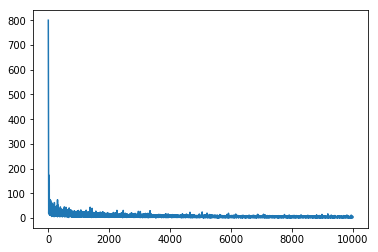

In [191]:
plt.plot(list(range(10000)), losses);

In [192]:
preds = predict(X_test, weights_nn)

### Investigation of most important features
Most important combination of features are the two with abs() > 9:

In [193]:
weights_nn['W2']

array([[  6.88181019],
       [  7.39079869],
       [  5.63204199],
       [  7.23579823],
       [  7.62525138],
       [  6.75401976],
       [  3.32508428],
       [  9.72867071],
       [  5.6010739 ],
       [-10.24687493],
       [  5.56446463],
       [  5.6762053 ],
       [ -4.40884115]])

The combinations that fit the criteria above as index 7 and 9

In [197]:
print("Weights with an abs() of 9.7: \n", weights_nn['W1'][7], "\n")
print("Weights with an abs() of 10.2: \n", weights_nn['W1'][9])

Weights with an abs() of 9.7: 
 [-3.35318091e+00 -4.67745141e-01  5.48100312e-01 -8.80425014e-02
  1.75362999e+00 -5.31114287e+00 -9.43127649e-01 -5.87300786e-01
 -1.23411490e-03  1.13747060e+00 -5.28009349e-01  1.15916033e+00
  1.60070328e+00] 

Weights with an abs() of 10.2: 
 [-2.6785258   3.92130586  2.23977236 -3.63226802 -0.22408348  3.18889016
  0.3231029   0.43162245 -1.97327924  0.24029253 -1.44634709 -0.50844719
  1.55610834]


In [198]:
print("Mean abs error: ", round(mae(preds, y_test), 4), "\n"
      "Root mean sqr error: ", round(rmse(preds, y_test), 4))

Mean abs error:  2.5951 
Root mean sqr error:  3.8851


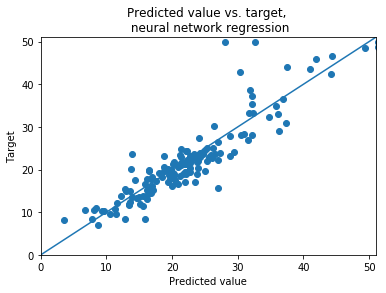

In [199]:
plt.xlabel("Predicted value")
plt.ylabel("Target")
plt.title("Predicted value vs. target, \n neural network regression")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0,51]);

In [200]:
np.round(np.mean(np.array(np.abs(preds - y_test))), 4)

2.5951

In [201]:
np.round(np.mean(np.array(np.power(preds - y_test, 2))), 4)

15.0943

### Theoretical relationship between most important feature and target

In [202]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = np.concatenate([a, b], axis=1)
preds_test = predict(test_feature, weights_nn)[:, 0]

Text(0.5, 1.0, 'Most important feature vs target and predictions \n Manual neural net regression')

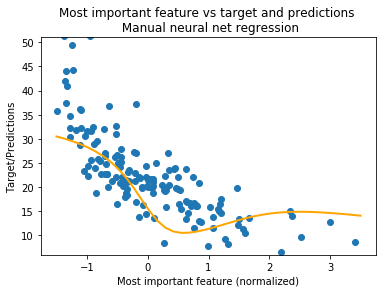

In [204]:
plt.scatter(X_test[:, 12], preds)
plt.plot(np.array(test_feature[:, -1]), preds_test, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs target and predictions \n Manual neural net regression")

SO here we can see that this is a drastically different plot than the same graph, but with linear regression. THis is because the neural network allows us to run essentially multiple regressions within one algorthim. Meaning we are able to run combinations of regressions vs just all of the features as a whole towards the target prediction. 

This is still something that I do not quite understand. I will be continuing through the book in hopes that something clicks. Incase it does not 'click' then I will be revisiting portions of this book again, and will continue to build a solid foundation through courses or other learning materials. 